Author: Jihoon Park

# Summary

This notebook is to demonstrate model inversion with Danish groundwater management. 

In [2]:
clear all; close all;
imatlab_export_fig('print-png')  % Static png figures.

# Load data

In [15]:
addpath('./DanishCase_NewData'); % old data are in /DanishCase_old
load Parameters.mat; load Forecasts.mat; load Data.mat
ParametersNames={'ma','kh1','kh2','kh3',...
    'ch1','ch2','ch3','ch4','ch5','riv1'...
    ,'riv2','riv3','riv4','riv\_elev1','riv\_elev2','riv\_elev3',...
    'riv\_elev4','drn1','drn2','drn3','drn4','drn\_elev1','drn\_elev2',...
    'drn\_elev3','drn\_elev4','rch1','bud\_in'};



# Apply mixed PCA to data variables

In [16]:
HeadDataOriginal=HeadData; % Copy the original data
Head=HeadDataOriginal(:,1:364); 
StreamFlow=HeadData(:,365:367);
[PCA1.coeff,PCA1.score,PCA1.EVs,~,PCA1.Explained]=pca(Head); PCA1.VarCumulative=cumsum(PCA1.Explained);
[PCA2.coeff,PCA2.score,PCA2.EVs,~,PCA2.Explained]=pca(StreamFlow); PCA2.VarCumulative=cumsum(PCA2.Explained);
PCA1.score=PCA1.score/sqrt(PCA1.EVs(1)); PCA2.score=PCA2.score/sqrt(PCA2.EVs(1));

Data_PC = [(PCA1.score),(PCA2.score)];

Using only the first 345 components to compute TSQUARED.
> In pca>localTSquared (line 511)
  In pca (line 357)


In [17]:
[PCAInfo.coeff, PCAInfo.score,PCAInfo.EVs,~,PCAInfo.Explained]=pca(Data_PC);
PCAInfo.VarCumulative=cumsum(PCAInfo.Explained);
PCAInfo.CutOff=.99;
PCAInfo.HowMany=find(PCAInfo.VarCumulative>(PCAInfo.CutOff*100)); 
PCAInfo.HowMany=PCAInfo.HowMany(1);


Using only the first 348 components to compute TSQUARED.
> In pca>localTSquared (line 511)
  In pca (line 357)


Let's see first two PCs

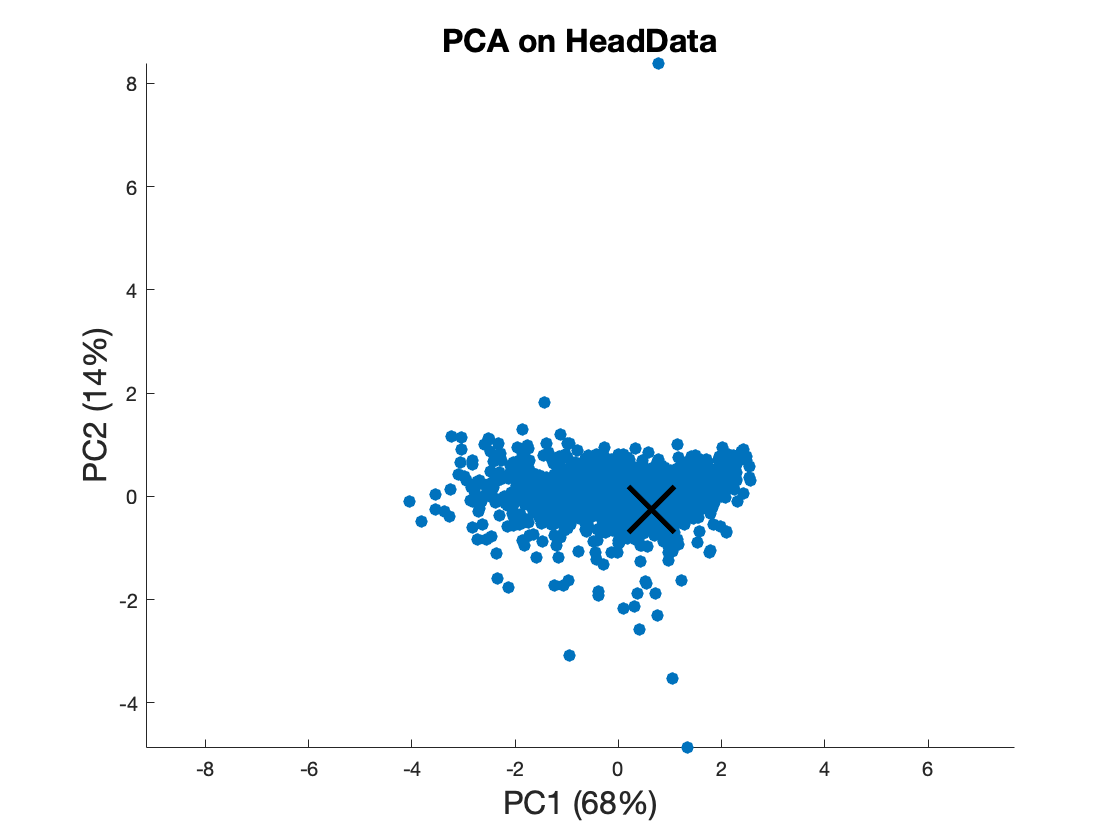

In [18]:
%% Visualize PCA Results.
DisplayPCAScores(PCAInfo.score,PCAInfo.Explained,'PCA on HeadData',40);
hold on; plot(PCAInfo.score(1,1),PCAInfo.score(1,2),'x','Color','k','Markersize',30,'LineWidth',3);

# Prepare training/test data

First set aside the reference

In [19]:
Data.All.Idx.TruthRealization=1;
Data.All.NParams=length(ParametersNames);
% If outlier is not removed
[Data.All.N, Data.All.k]=size(Data_PC); % 995 x 367 saved here.

Data.All.Idx.AllbutTruth=setdiff(1:Data.All.N, Data.All.Idx.TruthRealization); % 

Split train/test dataset 

In [20]:

Data.Train.Prop=.8; % 
Data.Train.N=round(length(Data.All.Idx.AllbutTruth)*Data.Train.Prop); % # of training examples.
Data.Test.N=length(Data.All.Idx.AllbutTruth)-Data.Train.N;
Data.Train.SplitSeed=11; rng(Data.Train.SplitSeed); % For reproducibility.

Data.Train.SampledIdx=randsample(1:length(Data.All.Idx.AllbutTruth),Data.Train.N); % This is the right sentence.
Data.Test.SampledIdx=setdiff(1:length(Data.All.Idx.AllbutTruth), Data.Train.SampledIdx);


Data.Train.X=ParamsValues(Data.Train.SampledIdx,:);
Data.Test.X=ParamsValues(Data.Test.SampledIdx,:);


Data.Train.Y_raw=PCAInfo.score(Data.Train.SampledIdx+1,1:PCAInfo.HowMany); 
Data.Test.Y_raw=PCAInfo.score(Data.Test.SampledIdx+1,1:PCAInfo.HowMany); 
Data.dobs=PCAInfo.score(Data.All.Idx.TruthRealization,1:PCAInfo.HowMany);


# Define y as L2 norm mismatch

In [21]:
Data.Train.Y=Data.Train.Y_raw-repmat(Data.dobs,Data.Train.N,1);
Data.Test.Y=Data.Test.Y_raw-repmat(Data.dobs,Data.Test.N,1);

Data.Train.Y=sqrt(sum(Data.Train.Y.^2,2)); 
Data.Test.Y=sqrt(sum(Data.Test.Y.^2,2)); 


# Regression modeling by boosted regression trees

If `Optimize=1`, the following code runs Bayseian optimzation. If 0, it uses cross-validation to optimze the parameters. You can specify the parameters that you want to optimize in `fitrensemble` which is called by `FitRegressionTree_v2`, such as:

```matlab

fitrensemble(X,Y(:,k),...
            'CategoricalPredictors', CategoricalIndices_input,'Method',...
            'LSBoost','Learner',templateTree('Surrogate','on'),...
            'OptimizeHyperparameters',{'NumLearningCycles','MaxNumSplits','LearnRate'},...
            'HyperparameterOptimizationOptions',struct('Repartition',true, 'MaxObjectiveEvaluations',MaxIters,...
            'AcquisitionFunctionName','expected-improvement-plus','Kfold',5),'PredictorNames',ParamsNames);
``` 


As seen above, three tuning parameters are optimized, which are `NumLearningCycles` (number of trees in boosting),`MaxNumSplits`,`LearnRate`

|====================================================================================================================|
| Iter | Eval   | Objective   | Objective   | BestSoFar   | BestSoFar   | NumLearningC-|    LearnRate | MaxNumSplits |
|      | result |             | runtime     | (observed)  | (estim.)    | ycles        |              |              |
|====================================================================================================================|
|    1 | Best   |     0.20595 |      16.842 |     0.20595 |     0.20595 |          331 |       0.4439 |            4 |
|    2 | Accept |     0.24187 |      1.1823 |     0.20595 |     0.20783 |           16 |       0.1229 |            4 |
|    3 | Accept |     0.75978 |      1.5035 |     0.20595 |     0.21123 |           15 |     0.044417 |          355 |
|    4 | Accept |     0.46942 |      7.1054 |     0.20595 |     0.21555 |          120 |    0.0091289 |           25 |
|    5 | Accept |     0.27471 |      19.617 |   

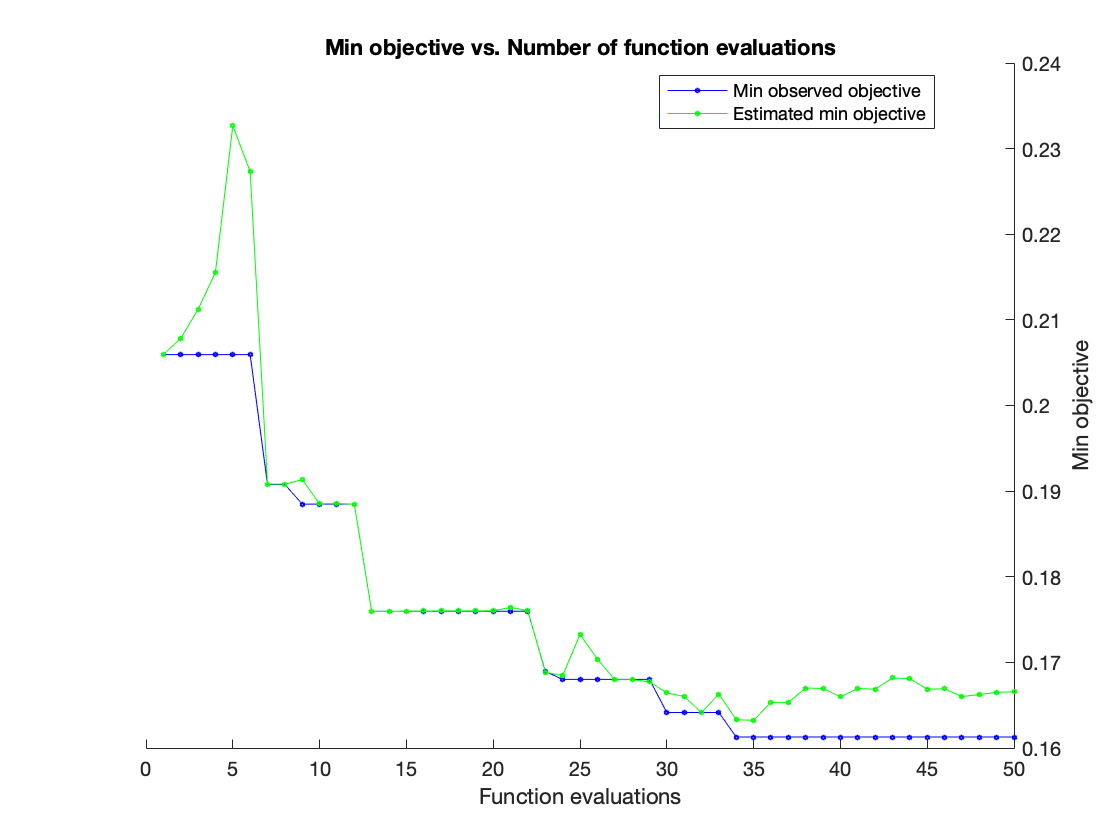

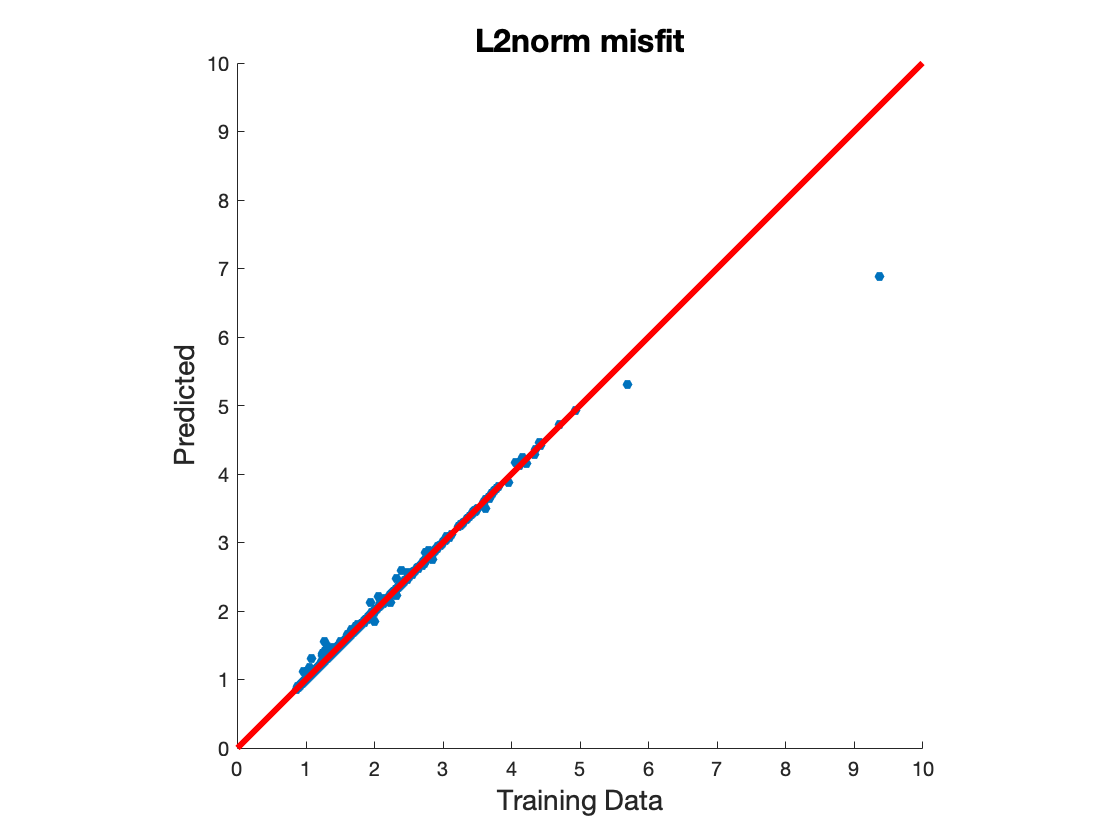

In [22]:
Data.RegResult=FitRegressionTree_v2(Data.Train.X,Data.Train.Y,ParametersNames,1,{'L2norm misfit'},50,1,1);

# Check the accuracy in terms of test data

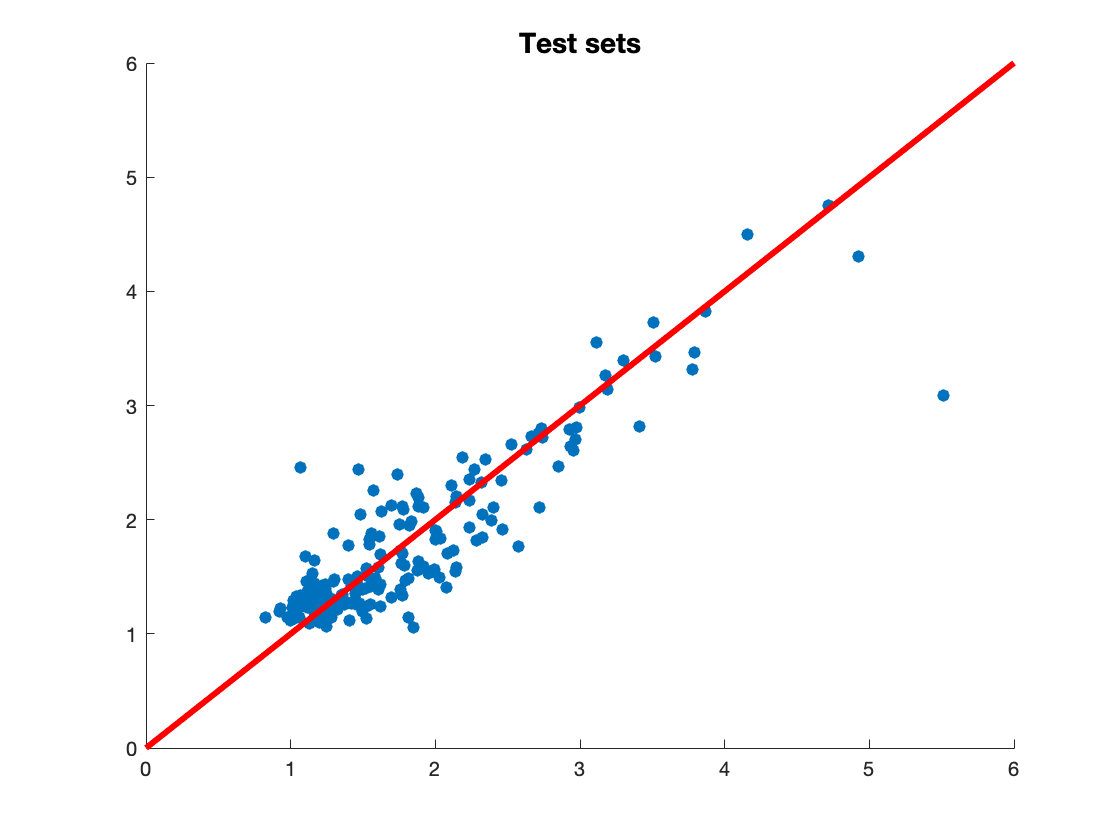

In [26]:
%[Data]=TestSetAnalysis(Data,{'L2 norm'}, 1);

%%
Data.RegResult{1}.TestPredicted=predict(Data.RegResult{1}.RegModels, Data.Test.X);
DisplayAllCrossPlots(Data.Test.Y,Data.RegResult{1}.TestPredicted,{'Test sets'},1,40);
Data.RegResult{1}.TestRMSE=sqrt(mean((Data.Test.Y-Data.RegResult{1}.TestPredicted).^2));
Data.RegResult{1}.Corr=corr(Data.Test.Y,Data.RegResult{1}.TestPredicted);